In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import numpy as np
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

print('Current working directory: ',os.getcwd())

Current working directory:  /home/rrochas/prediction-validation


In [18]:
# target_data = 'PeMS08_flow'
target_data  = 'subway_in'


def load_save_and_get_horizons(model_name,target_data,p):
    folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',f'{target_data}_{p}p')
    results = pd.read_csv(f'{folder_path}/METRICS_{target_data}_{p}p.csv',index_col = 0)

    mae_metrics = [c for c in results.columns if ('mae' in c) and (not 'VAR' in c) and not ('complete' in c)]
    mae_metrics  = [int(c.split('h')[-1]) for c in mae_metrics]
    horizon_max = int(np.max(np.array(mae_metrics)))
    return results,horizon_max


metrics = ['mae','rmse','mape','mase']
for model_name in ['STGCN','STAEformer']:
    for metric in metrics:
        _,horizon_max = load_save_and_get_horizons(model_name,target_data,100)
        globals()[f"{model_name}_{metric}_list"] = []
        globals()[f"{model_name}_{metric}_list_h1"] = []
        globals()[f"{model_name}_{metric}_list_h{horizon_max//2}"] = []
        globals()[f"{model_name}_{metric}_list_h{horizon_max}"] = []


# percentage_list = [50,75,80,85,90,95,100]# [10,15,25,35,50,75,80,85,90,95,100]
percentage_list = [10,15,25,35,50,75,80,85,90,95,100]
for model_name in ['STGCN','STAEformer']:
    # build list of metrics for each percentage
    for p in percentage_list:
        results,horizon_max = load_save_and_get_horizons(model_name,target_data,p)

        for metric in metrics:
            selected_columns = [c for c in results.columns if (c.startswith(metric)) and not 'complete' in c]
            metric_all = results[selected_columns].mean(axis=1)['test']
            globals()[f"{model_name}_{metric}_list"].append(metric_all)
            globals()[f"{model_name}_{metric}_list_h1"].append(results[selected_columns][f"{metric}_h1"]['test'])
            globals()[f"{model_name}_{metric}_list_h{horizon_max//2}"].append(results[selected_columns][f"{metric}_h{horizon_max//2}"]['test'])
            globals()[f"{model_name}_{metric}_list_h{horizon_max}"].append(results[selected_columns][f"{metric}_h{horizon_max}"]['test'])


    # ...
    
    globals()[f"df_{model_name}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_list"] for metric in metrics})
    globals()[f"df_{model_name}_h1"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_list_h1"] for metric in metrics})
    globals()[f"df_{model_name}_h{horizon_max//2}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_list_h{horizon_max//2}"] for metric in metrics})
    globals()[f"df_{model_name}_h{horizon_max}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_list_h{horizon_max}"] for metric in metrics})

    globals()[f"df_{model_name}"].index = percentage_list
    globals()[f"df_{model_name}_h1"].index = percentage_list
    globals()[f"df_{model_name}_h{horizon_max//2}"].index = percentage_list
    globals()[f"df_{model_name}_h{horizon_max}"].index = percentage_list

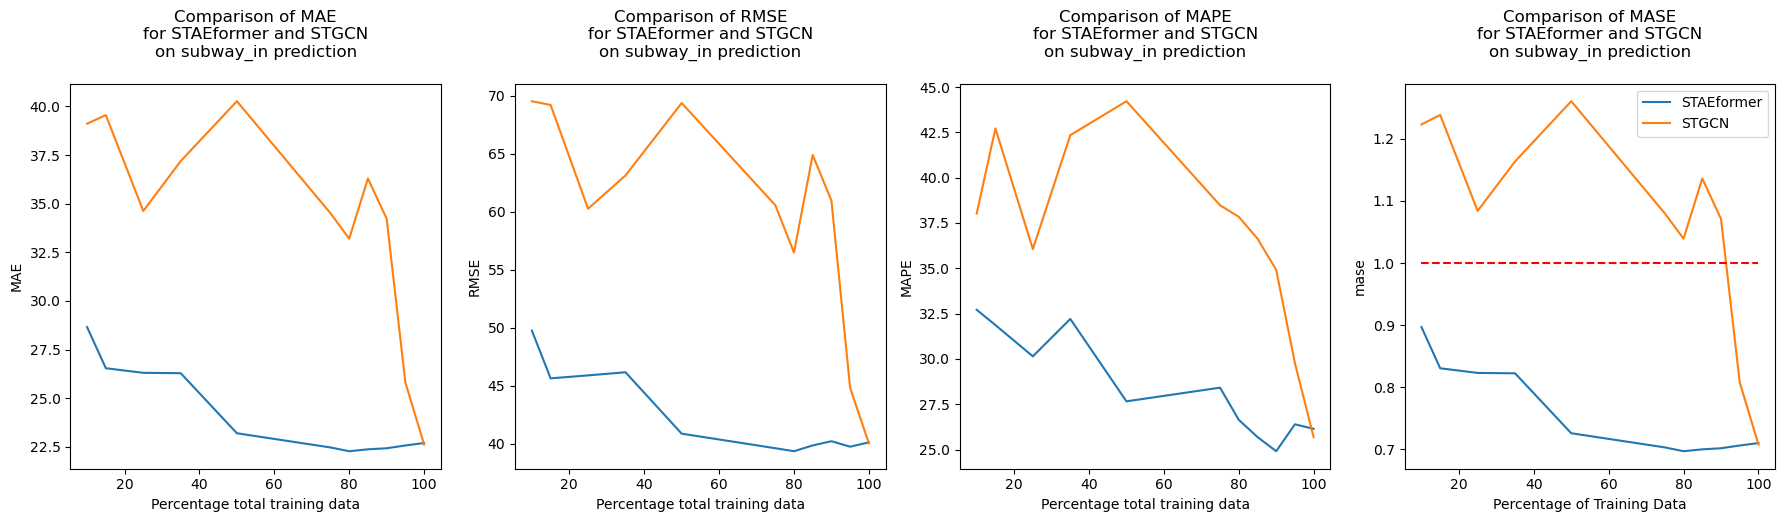

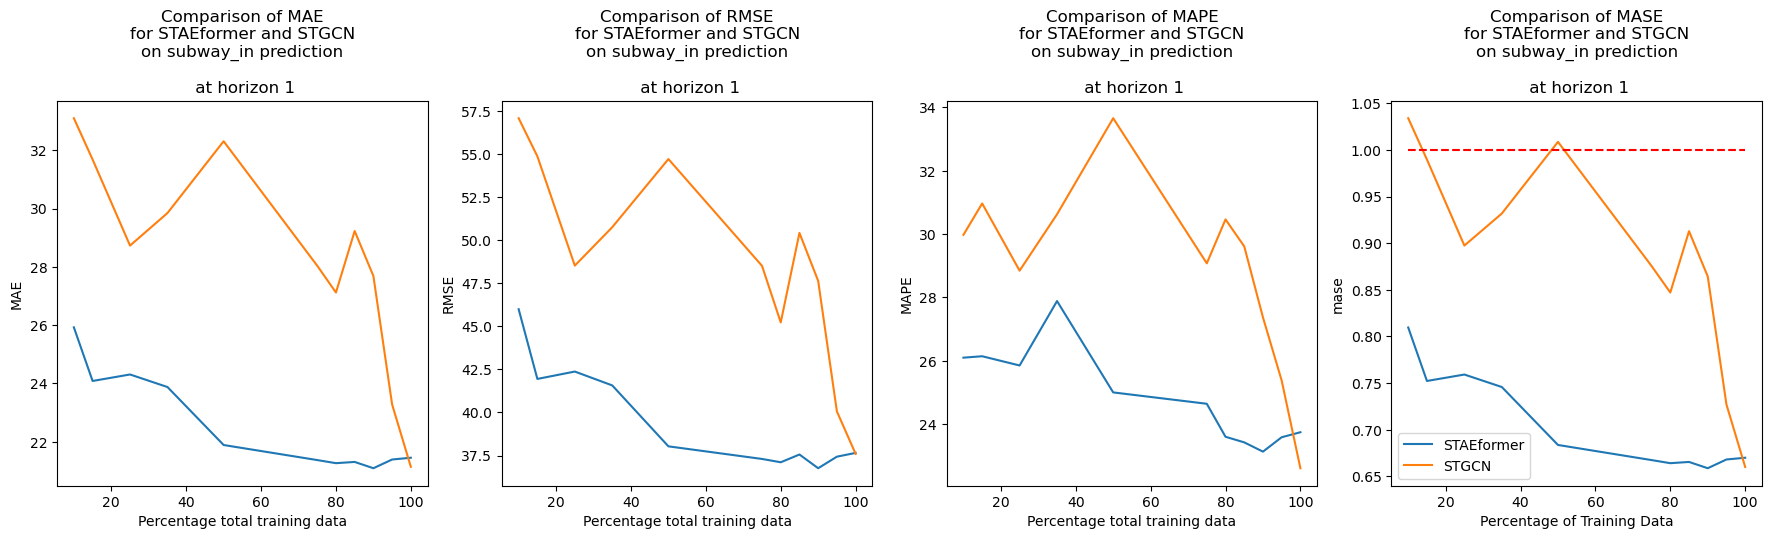

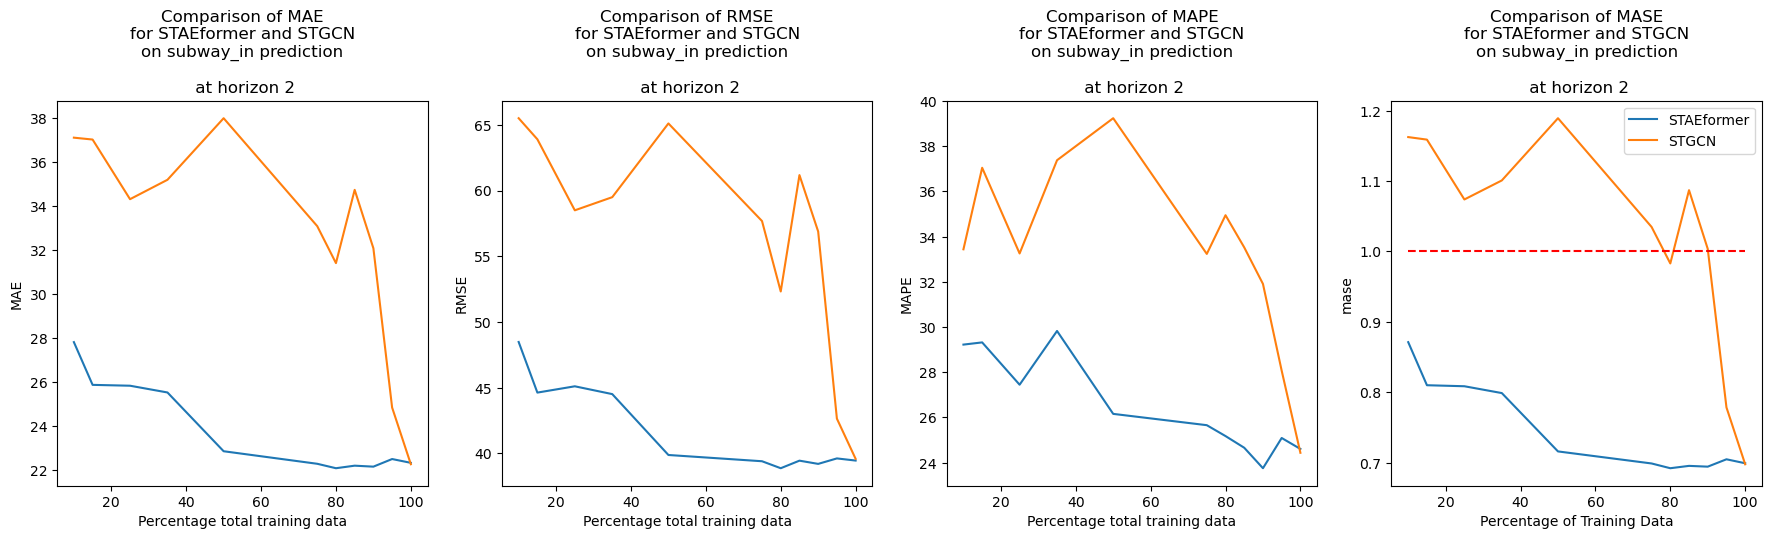

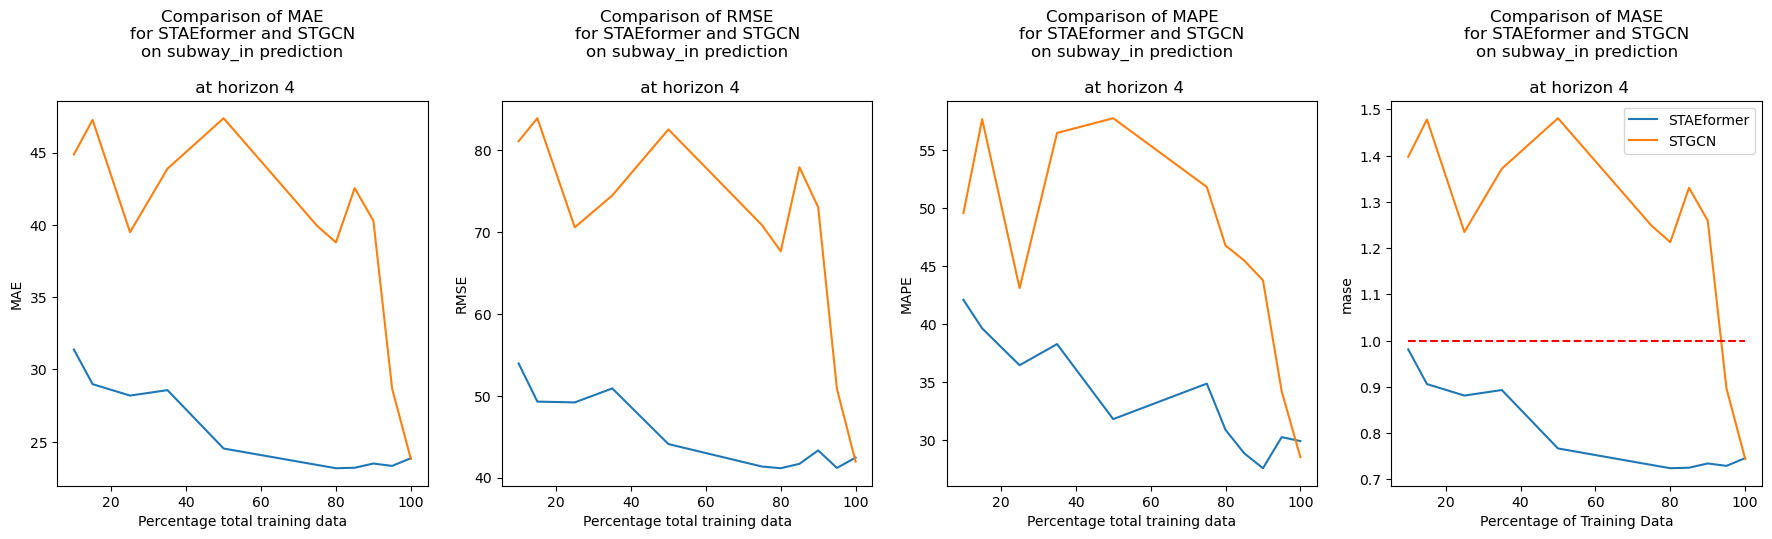

In [19]:
import matplotlib.pyplot as plt

for horizon in [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]:
    fig, axes = plt.subplots(1,len(metrics),figsize=(22, 5))
    for k,metric in enumerate(metrics): 
        for model_name in ['STGCN','STAEformer']:
            axes[k].plot(globals()[f"df_{model_name}{horizon}"][metric].index,globals()[f"df_{model_name}{horizon}"][metric])
        title = f'Comparison of {metric.upper()}\nfor STAEformer and STGCN\non {target_data} prediction\n'
        if horizon != '':
            title = f"{title}\n at horizon {horizon[2:]}"
        axes[k].set_title(title)
        axes[k].set_xlabel('Percentage total training data')
        axes[k].set_ylabel(metric.upper())
        #plt.xticks(range(len(percentage_list)), percentage_list)
        plt.ylabel(metric)
        plt.xlabel('Percentage of Training Data')
        plt.legend(['STAEformer', 'STGCN'])
        if metric == 'mase':
            axes[k].plot([np.min(np.array(percentage_list)), 100], [1, 1], color='red', linestyle='--', label='MASE = 1')
    plt.show()